<a href="https://colab.research.google.com/github/Signorte/colab_MLDL_HandsOn/blob/master/%E7%AC%AC%E4%B8%89%E5%9B%9E%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%8F%E3%83%B3%E3%82%BA%E3%82%AA%E3%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

必要なライブラリの読み込み

In [0]:
!pip install eli5

     |████████████████████████████████| 112kB 5.1MB/s 


In [0]:
# コピー
import copy

# 数理計算
import numpy as np
from scipy.sparse import csr_matrix

# csv読み込み
import pandas as pd

# 可視化系
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
sns.set()

# 機械学習モデル
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# 評価指標計算
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# データ分割
from sklearn.model_selection import train_test_split

# 特徴量の重要度を出す
import eli5
from eli5.sklearn import PermutationImportance

# google driveとの接続
from google.colab import drive

Using TensorFlow backend.


##### 可視化を行う関数を定義

In [0]:
def plot_decision_regions(model):
  h = 0.02
  
  x_min = city_data["Medical"].min() - 1
  x_max = city_data["Medical"].max() + 1
  y_min=city_data["Culture"].min() - 1
  y_max =city_data["Culture"].max() + 1

  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
    
  plt.contourf(xx, yy, Z, cmap=plt.cm.terrain, alpha=0.5,linewidths=0)
  plt.scatter(city_data["Medical"], city_data["Culture"], c=color_data, cmap=plt.cm.Dark2)
    
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

# 0. 前回の復習

国勢調査のデータのダウンロード

In [0]:
!wget http://news.mynavi.jp/series/Python_ML/005/resources/consumerPrices_tree.csv

--2019-11-19 06:45:14--  http://news.mynavi.jp/series/Python_ML/005/resources/consumerPrices_tree.csv
Resolving news.mynavi.jp (news.mynavi.jp)... 13.224.2.30, 13.224.2.78, 13.224.2.100, ...
Connecting to news.mynavi.jp (news.mynavi.jp)|13.224.2.30|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://news.mynavi.jp/series/Python_ML/005/resources/consumerPrices_tree.csv [following]
--2019-11-19 06:45:14--  https://news.mynavi.jp/series/Python_ML/005/resources/consumerPrices_tree.csv
Connecting to news.mynavi.jp (news.mynavi.jp)|13.224.2.30|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://news.mynavi.jp/article/Python_ML-5/resources/consumerPrices_tree.csv [following]
--2019-11-19 06:45:14--  https://news.mynavi.jp/article/Python_ML-5/resources/consumerPrices_tree.csv
Reusing existing connection to news.mynavi.jp:443.
HTTP request sent, awaiting response... 200 OK
Length: 3255 (3.2K) [text/csv]

In [0]:
city_data = pd.read_csv("consumerPrices_tree.csv")  # ダウンロードしたcsvデータを読み込み
city_data = city_data[["都道府県", "保険医療", "教養娯楽", "大都市圏分類"]]  # 使用する列だけ抽出
city_data.columns = ["Name", "Medical", "Culture", "BigCity"]  # 列名を英語に
city_data.head()

,Name,Medical,Culture,BigCity
0,北 海 道,100.2,97.1,1
1,青 森 県,101.0,96.4,0
2,岩 手 県,100.4,99.8,0
3,宮 城 県,100.9,99.3,1
4,秋 田 県,98.9,98.0,0


##### 問題1

ロジスティック回帰でモデルを学習してみましょう  
モデルの名前は `lr_model` にして下さい

In [0]:
X = city_data[["Medical", "Culture"]]  # 特徴量
y = city_data["BigCity"]  # 正解ラベル(大都市なら1, そうじゃないなら0)

In [0]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

##### 解答

In [0]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

##### 問題2
ロジステック回帰モデルの特徴境界面を可視化してみましょう

In [0]:
color_data = city_data["BigCity"].map({0:"b",1:"r"})  #  可視化用の色の定義

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: linewidths is ignored by contourf
  


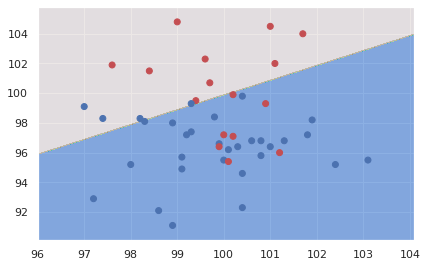

In [0]:
plot_decision_regions(lr_model)

##### ヒント

In [0]:
# 最初に定義した plot_decision_regions 関数が使えます

##### 解答

In [0]:
plot_decision_regions(lr_model)

##### 問題3
決定木で同じデータの学習を行い、過学習を起こしてみて下さい  
モデルの名前は `tree_model` にして下さい

In [0]:
tree_model = DecisionTreeClassifier(random_state=0, max_depth=10)
tree_model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

##### ヒント

In [0]:
# max_depth というパラメーターが関わります

##### 解答

In [0]:
tree_model = DecisionTreeClassifier(random_state=0, max_depth=10)
tree_model.fit(X, y)

##### 問題4
過学習した決定木モデルの特徴境界面を可視化してみましょう

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: linewidths is ignored by contourf
  


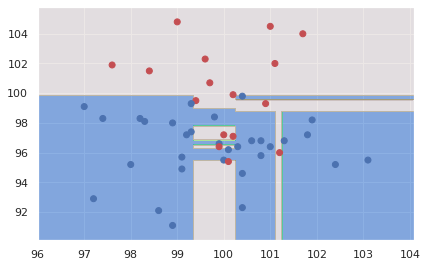

In [0]:
plot_decision_regions(tree_model)

##### ヒント

In [0]:
# 最初に定義した plot_decision_regions 関数が使えます

##### 解答

In [0]:
plot_decision_regions(tree_model)

##### 問題5

過学習と未学習について

###### バイアスが高いときはどちらですか？

In [0]:
# 未学習

##### 問題の難しさ <<< モデルの複雑さ のときは？

In [0]:
# 過学習

##### 学習した結果の境界が緑のときは？
![代替テキスト](http://cad18c2657e819f4a2f4-c118f1ab3b113c2c8f3867f2c01792f2.r6.cf1.rackcdn.com/global/imagelib/machine_learning/overfitting.svg.png)

In [0]:
# 過学習

##### ここからタイタニックのデータを使います

In [0]:
!wget https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv  # データのダウンロード

--2019-11-19 06:46:41--  https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44225 (43K) [text/csv]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  43.19K  --.-KB/s    in 0.02s   

2019-11-19 06:46:41 (2.00 MB/s) - ‘titanic.csv’ saved [44225/44225]



In [0]:
titanic_data = pd.read_csv("titanic.csv")  # データの読み込み
titanic_data["SexCate"] = titanic_data["Sex"].map({"male": 0, "female":1})  # 性別カテゴリの作成

train, test = train_test_split(titanic_data, test_size=0.3, random_state=0)  # データの分割

use_feature = ["Pclass", "Age", "Siblings/Spouses Aboard", "Parents/Children Aboard", "Fare", "SexCate"]

x_train = train[use_feature]
x_test = test[use_feature]
y_train = train["Survived"]
y_test = test["Survived"]

##### 問題6

学習データ、テストデータを引数に取るとロジスティック回帰の学習を行い精度を表示する関数 `train_and_test` を作って下さい

In [0]:
def train_and_test(x_train, y_train, x_test, y_test):
  model = LogisticRegression(random_state=0)
  model.fit(x_train, y_train)
  pred_train = model.predict(x_train)
  pred_test = model.predict(x_test)
  acc_train = accuracy_score(y_train, pred_train)
  acc_test = accuracy_score(y_test, pred_test)
  print(f"train: {acc_train} / test: {acc_test}")

##### 解答

In [0]:
def train_and_test(x_train, y_train, x_test, y_test):
    model = LogisticRegression(random_state=0)
    model.fit(x_train, y_train)
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)
    acc_train = accuracy_score(y_train, pred_train)
    acc_test = accuracy_score(y_test, pred_test)
    print(f"train: {acc_train} / test: {acc_test}")

##### 問題7
特徴量を追加して、追加する前との精度の変化を見てみましょう

In [0]:
x_train_2 = copy.deepcopy(x_train)
x_test_2 = copy.deepcopy(x_test)

In [0]:
x_train_2["isChild"] = (x_train['Age'] < 10).astype(int)
x_test_2["isChild"] = (x_test['Age'] < 10).astype(int)

train_and_test(x_train, y_train, x_test, y_test)
train_and_test(x_train_2, y_train, x_test_2, y_test)

train: 0.8032258064516129 / test: 0.797752808988764
train: 0.8145161290322581 / test: 0.8127340823970037


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


##### 解答

一例です  
10歳未満か否かの`isChild`を追加

In [0]:
x_train_2["isChild"] = (x_train['Age'] < 10).astype(int)
x_test_2["isChild"] = (x_test['Age'] < 10).astype(int)

train_and_test(x_train, y_train, x_test, y_test)
train_and_test(x_train_2, y_train, x_test_2, y_test)

##### 問題8
追加した特徴量の寄与度を可視化してみましょう

In [0]:
# モデルの作成
lr_model = LogisticRegression(random_state=0)
lr_model.fit(x_train_2, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
perm = PermutationImportance(lr_model).fit(x_test_2, y_test)

eli5.show_weights(perm, feature_names=x_test_2.columns.tolist())  # 可視化を行う関数

Weight,Feature
0.2449 ± 0.0568,SexCate
0.0472 ± 0.0122,Pclass
0.0315 ± 0.0302,Age
0.0202 ± 0.0168,Siblings/Spouses Aboard
0.0112 ± 0.0095,Parents/Children Aboard
0.0097 ± 0.0060,Fare
0.0097 ± 0.0154,isChild


##### ヒント

In [0]:
# PermutationImportance を使います

##### 解答

In [0]:
perm = PermutationImportance(lr_model).fit(x_test_2, y_test)

eli5.show_weights(perm, feature_names=x_test_2.columns.tolist())

##### 下記のような混同行列があります

||Negative(予測)|Positive(予測)|
|:--|:--:|:--:|
|Negative(正解)|12|7|
|Positive(正解)|4|53|

##### 問題9
PositiveのPrecisionはいくらですか？


In [0]:
# Precisionは TP / (TP + FP)
# ここのだと 53 / (53 + 7)
# 約0.883

##### 問題10
PositiveのRecallはいくらですか？

In [0]:
# Recallは TP / (TP + FN)
# ここだと 53 / (53 + 4)
# 約0.93

# 1. 教師なし学習

今回使用するデータ  
https://www.kaggle.com/CooperUnion/anime-recommendations-database

Kaggleのアニメお勧めデータベース

Google Driveをマウントする

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# マウントしたドライブの確認
!ls '/content/drive'

'My Drive'  'Shared drives'


In [0]:
!ls '/content/drive/My Drive/ai_hans_on/hans_on_3'

anime.csv  rating.csv


読み込んでデータを眺めてみる

In [0]:
anime = pd.read_csv("/content/drive/My Drive/ai_hans_on/hans_on_3/anime.csv")
print(anime.shape)
anime.head()

(12294, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [0]:
rating = pd.read_csv("/content/drive/My Drive/ai_hans_on/hans_on_3/rating.csv")
print(rating.shape)
rating.head(10)

(7813737, 3)


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


欠損値の確認

In [0]:
anime.isnull().sum(0)

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [0]:
rating.isnull().sum(0)

user_id     0
anime_id    0
rating      0
dtype: int64

欠損値の補完

In [0]:
anime2 = anime.dropna()

In [0]:
anime2.isnull().sum(0)  # 再度確認

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

データ数の確認

In [0]:
anime.shape, anime2.shape

((12294, 7), (12017, 7))

In [0]:
rating.shape

(7813737, 3)

# 演習1

anime2とratingのデータ分析をしてみましょう

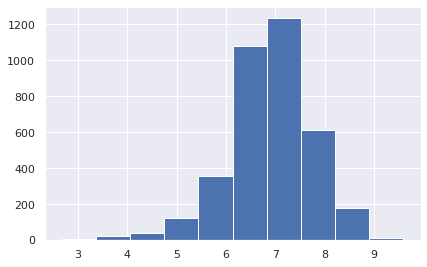

In [0]:
anime2[anime2["type"] == "TV"]["rating"].hist()
# 評価6-7が多そう

##### ヒント

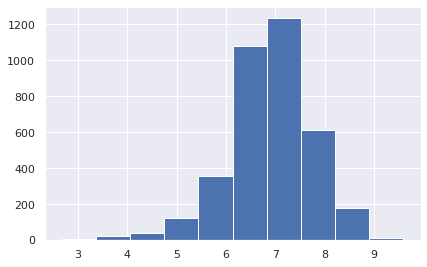

In [0]:
# type = TV のrating(平均評価)を調べたいときは下記のように書きます
anime2[anime2["type"] == "TV"]["rating"].hist()

##### 解答

一例です

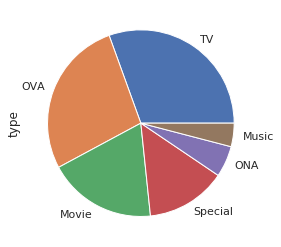

In [0]:
anime2["type"].value_counts().plot.pie()

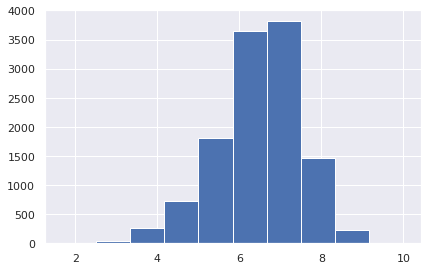

In [0]:
anime2["rating"].hist()

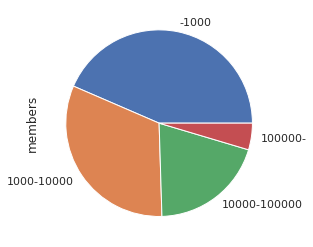

In [0]:
def norm_member(x):
  if x < 1000:
    return "-1000"
  elif 1000 < x < 10000:
    return "1000-10000"
  elif 10000 < x < 100000:
    return "10000-100000"
  else:
    return "100000-"
   

anime2["members"].map(norm_member).value_counts().plot.pie()

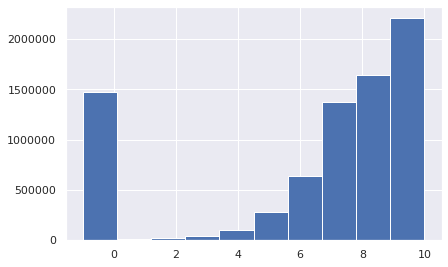

In [0]:
rating["rating"].hist()

##### データを絞る
10,000人以上が見ているアニメに絞る

In [0]:
anime3 = anime2[anime2["members"] > 10000]

In [0]:
anime.shape, anime2.shape, anime3.shape

((12294, 7), (12017, 7), (2946, 7))

評価していない人は除く

In [0]:
rating2 = rating[rating["rating"] != -1]

In [0]:
rating.shape, rating2.shape

((7813737, 3), (6337241, 3))

データを連結する

In [0]:
anime_data = rating2.merge(anime3, left_on='anime_id', right_on='anime_id', suffixes= ['_user', ''])
anime_data.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
2,5,8074,2,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
3,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
4,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892


使用する情報だけに絞る

今回はユーザーとタイトルとそのユーザーの評価

In [0]:
anime_data2 = anime_data[['user_id','name','rating_user']]
anime_data2.head()

,user_id,name,rating_user
0,1,Highschool of the Dead,10
1,3,Highschool of the Dead,6
2,5,Highschool of the Dead,2
3,12,Highschool of the Dead,6
4,14,Highschool of the Dead,6


データの重複を確認

In [0]:
anime_data2[anime_data2.duplicated(keep=False, subset=['user_id','name'])]

,user_id,name,rating_user
48054,42653,Sword Art Online,8
48055,42653,Sword Art Online,5
444785,42653,Shingeki no Kyojin,8
444786,42653,Shingeki no Kyojin,8
523332,42653,Noragami,7
523333,42653,Noragami,9
574059,42653,Tokyo Ghoul,8
574060,42653,Tokyo Ghoul,6
2333281,42653,Code Geass: Hangyaku no Lelouch,8
2333282,42653,Code Geass: Hangyaku no Lelouch,6


重複を除去

In [0]:
anime_data3 = anime_data2.drop_duplicates(keep="last", subset=['user_id','name'])

In [0]:
anime_data3[anime_data3.duplicated(keep=False, subset=['user_id','name'])]

,user_id,name,rating_user


In [0]:
anime_data2.shape, anime_data3.shape

((5957004, 3), (5956997, 3))

タイトルごとのユーザー評価テーブルを作成する

In [0]:
anime_data_pivot = anime_data3.pivot(index='name', columns='user_id', values='rating_user').fillna(0)  # 縦にname 横にuser_id をとって値を rating_user とする（空欄は0で埋める）
anime_data_pivot.head()

user_id,1,2,3,5,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,43,44,...,73476,73478,73479,73480,73481,73482,73483,73484,73485,73486,73487,73488,73489,73490,73491,73492,73493,73494,73495,73496,73497,73498,73499,73500,73501,73502,73503,73504,73505,73506,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Returner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


一旦スライドに戻りましょう

# 2. レコメンドを実装してみる

In [0]:
anime_data_pivot.shape

#(user, anime)

(2885, 69498)

#### アニメのタイトルを検索する関数

アニメのタイトルはサブタイトル含め英語で入っているため、文字列一致で検索する関数を作る

In [0]:
def search_anime(string):
    print(anime_data_pivot[anime_data_pivot.index.str.contains(string)].index[0:])

中で何をしているのか

In [0]:
string = "Dragon Ball"  # ドラゴンボールで検索してみる

In [0]:
anime_data_pivot.head(2)

user_id,1,2,3,5,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,43,44,...,73476,73478,73479,73480,73481,73482,73483,73484,73485,73486,73487,73488,73489,73490,73491,73492,73493,73494,73495,73496,73497,73498,73499,73500,73501,73502,73503,73504,73505,73506,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
anime_titles = anime_data_pivot.index  # タイトルの列を抜き出す
anime_titles

Index(['&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi',
       '&quot;Bungaku Shoujo&quot; Memoire',
       '&quot;Bungaku Shoujo&quot; Movie', '.hack//G.U. Returner',
       '.hack//G.U. Trilogy', '.hack//Gift', '.hack//Intermezzo',
       '.hack//Liminality', '.hack//Quantum', '.hack//Roots',
       ...
       'ef: A Tale of Melodies. - Prologue', 'ef: A Tale of Memories.',
       'ef: A Tale of Memories. - Prologue', 'iDOLM@STER Xenoglossia',
       's.CRY.ed', 'xxxHOLiC', 'xxxHOLiC Kei',
       'xxxHOLiC Movie: Manatsu no Yoru no Yume', 'xxxHOLiC Rou',
       'xxxHOLiC Shunmuki'],
      dtype='object', name='name', length=2885)

In [0]:
is_title = anime_titles.str.contains(string)  # 文字列 string(ここでは "Dragon Ball") が含まれるか否か
is_title

array([False, False, False, ..., False, False, False])

In [0]:
anime_titles[is_title]  # is_title == True のみ抽出

Index(['Dragon Ball', 'Dragon Ball GT',
       'Dragon Ball GT: Goku Gaiden! Yuuki no Akashi wa Suushinchuu',
       'Dragon Ball Kai', 'Dragon Ball Kai (2014)',
       'Dragon Ball Kai: Mirai ni Heiwa wo! Goku no Tamashii yo Eien ni',
       'Dragon Ball Movie 1: Shen Long no Densetsu',
       'Dragon Ball Movie 2: Majinjou no Nemuri Hime',
       'Dragon Ball Movie 3: Makafushigi Daibouken',
       'Dragon Ball Movie 4: Saikyou e no Michi', 'Dragon Ball Specials',
       'Dragon Ball Z', 'Dragon Ball Z Movie 01: Ora no Gohan wo Kaese!!',
       'Dragon Ball Z Movie 02: Kono Yo de Ichiban Tsuyoi Yatsu',
       'Dragon Ball Z Movie 03: Chikyuu Marugoto Choukessen',
       'Dragon Ball Z Movie 04: Super Saiyajin da Son Gokuu',
       'Dragon Ball Z Movie 05: Tobikkiri no Saikyou tai Saikyou',
       'Dragon Ball Z Movie 06: Gekitotsu!! 100-oku Power no Senshi-tachi',
       'Dragon Ball Z Movie 07: Kyokugen Battle!! Sandai Super Saiyajin',
       'Dragon Ball Z Movie 08: Moetsukiro!! Ne

## 強調フィルタリングを実装してみる

cos類似度を使って各アニメ間の距離を計算する

In [0]:
search_anime('Conan')

Index(['Detective Conan Movie 01: The Timed Skyscraper',
       'Detective Conan Movie 02: The Fourteenth Target',
       'Detective Conan Movie 03: The Last Wizard of the Century',
       'Detective Conan Movie 04: Captured in Her Eyes',
       'Detective Conan Movie 05: Countdown to Heaven',
       'Detective Conan Movie 06: The Phantom of Baker Street',
       'Detective Conan Movie 07: Crossroad in the Ancient Capital',
       'Detective Conan Movie 08: Magician of the Silver Sky',
       'Detective Conan Movie 09: Strategy Above the Depths',
       'Detective Conan Movie 10: Requiem of the Detectives',
       'Detective Conan Movie 11: Jolly Roger in the Deep Azure',
       'Detective Conan Movie 12: Full Score of Fear',
       'Detective Conan Movie 13: The Raven Chaser',
       'Detective Conan Movie 14: The Lost Ship in the Sky',
       'Detective Conan Movie 15: Quarter of Silence',
       'Detective Conan Movie 16: The Eleventh Striker',
       'Detective Conan Movie 17: Priv

In [0]:
# 対象アニメの行を取得
title = "Dragon Ball Z"
target_anime_1 = anime_data_pivot.iloc[anime_data_pivot.index == title]
target_anime_1

user_id,1,2,3,5,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,43,44,...,73476,73478,73479,73480,73481,73482,73483,73484,73485,73486,73487,73488,73489,73490,73491,73492,73493,73494,73495,73496,73497,73498,73499,73500,73501,73502,73503,73504,73505,73506,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Dragon Ball Z,0.0,0.0,10.0,5.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,8.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,5.0,0.0,0.0,8.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# 対象アニメの行を取得
title = "Naruto"
target_anime_2 = anime_data_pivot.iloc[anime_data_pivot.index == title]
target_anime_2

user_id,1,2,3,5,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,43,44,...,73476,73478,73479,73480,73481,73482,73483,73484,73485,73486,73487,73488,73489,73490,73491,73492,73493,73494,73495,73496,73497,73498,73499,73500,73501,73502,73503,73504,73505,73506,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Naruto,0.0,0.0,8.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,6.0,10.0,0.0,10.0,0.0,8.0,0.0,...,0.0,0.0,0.0,7.0,9.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,10.0,7.0,10.0,8.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# 対象アニメの行を取得
title = "Detective Conan Movie 01: The Timed Skyscraper"
target_anime_3 = anime_data_pivot.iloc[anime_data_pivot.index == title]
target_anime_3

user_id,1,2,3,5,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,43,44,...,73476,73478,73479,73480,73481,73482,73483,73484,73485,73486,73487,73488,73489,73490,73491,73492,73493,73494,73495,73496,73497,73498,73499,73500,73501,73502,73503,73504,73505,73506,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Detective Conan Movie 01: The Timed Skyscraper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# ベクトル化
target_vec_1 = target_anime_1.values 
target_vec_2 = target_anime_2.values 
target_vec_3 = target_anime_3.values 
target_vec_1

array([[ 0.,  0., 10., ...,  0.,  0.,  0.]])

In [0]:
# ドラゴンボール vs ナルト
cosine_similarity(target_vec_1, target_vec_2)

array([[0.45740815]])

In [0]:
# ドラゴンボール vs コナン
cosine_similarity(target_vec_1, target_vec_3)

array([[0.12150638]])

In [0]:
# ナルト vs コナン
cosine_similarity(target_vec_2, target_vec_3)

array([[0.12011024]])

すべてのアニメと比較してみる

In [0]:
all_vecs = anime_data_pivot.values
all_vecs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
# ドラゴンボール vs 他すべて
all_sim = cosine_similarity(target_vec_1, all_vecs)
all_sim

array([[0.06105978, 0.06263422, 0.08327553, ..., 0.10921153, 0.09079535,
        0.10446003]])

In [0]:
sort_i = all_sim[0].argsort()[::-1]  # 降順にソートしたときのインデックスを持ってくる
sort_i

array([ 619,  608,  609, ..., 1402,  136, 2264])

In [0]:
anime_data_pivot.index[sort_i]  # アニメの取得

Index(['Dragon Ball Z', 'Dragon Ball', 'Dragon Ball GT', 'Naruto',
       'Death Note',
       'Dragon Ball Z Movie 08: Moetsukiro!! Nessen, Ressen, Chougekisen',
       'Fullmetal Alchemist',
       'Dragon Ball Z Movie 05: Tobikkiri no Saikyou tai Saikyou',
       'Dragon Ball Z Movie 03: Chikyuu Marugoto Choukessen',
       'Dragon Ball Z Movie 01: Ora no Gohan wo Kaese!!',
       ...
       'Kizumonogatari II: Nekketsu-hen', 'Koe no Katachi',
       'Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka OVA',
       'Ajin Part 2: Shoutotsu', 'Aikatsu!',
       'Yu☆Gi☆Oh!: The Dark Side of Dimensions', 'Orange: Mirai',
       'Koro-sensei Q!', 'Ansatsu Kyoushitsu: 365-nichi no Jikan',
       'Seitokai Yakuindomo* OVA'],
      dtype='object', name='name', length=2885)

In [0]:
n_show = 5 # 何件見せるか
for rank, idx in enumerate(sort_i):
  if rank == 0:  # 1番近いのは自分自身なのでスキップ
    continue
  print("類似度:", all_sim[0][idx])
  print("タイトル:", anime_data_pivot.index[idx])
  print()
  if rank > n_show:
    break

類似度: 0.7616705639109382
タイトル: Dragon Ball

類似度: 0.724290460078516
タイトル: Dragon Ball GT

類似度: 0.4574081466474529
タイトル: Naruto

類似度: 0.44788702775303846
タイトル: Death Note

類似度: 0.4314398328701657
タイトル: Dragon Ball Z Movie 08: Moetsukiro!! Nessen, Ressen, Chougekisen

類似度: 0.4137075322327213
タイトル: Fullmetal Alchemist



##### 演習
これまでのコードをまとめて、タイトルを入れるとおすすめアニメを5件推薦してくれる関数を作りましょう

In [0]:
def recomend_anime(title, n=5):
  target_anime_vec = anime_data_pivot.iloc[anime_data_pivot.index == title].values
  all_sim = cosine_similarity(target_anime_vec, all_vecs)
  sort_i = all_sim[0].argsort()[::-1] 

  for rank, idx in enumerate(sort_i):
    if rank == 0:  # 1番近いのは自分自身なのでスキップ
      continue
    print("類似度:", all_sim[0][idx])
    print("タイトル:", anime_data_pivot.index[idx])
    print()
    if rank > n:
      break

##### 解答

In [0]:
def recomend_anime(title, n=5):
  target_anime_vec = anime_data_pivot.iloc[anime_data_pivot.index == title].values
  all_sim = cosine_similarity(target_anime_vec, all_vecs)
  sort_i = all_sim[0].argsort()[::-1] 

  for rank, idx in enumerate(sort_i):
    if rank == 0:  # 1番近いのは自分自身なのでスキップ
      continue
    print("類似度:", all_sim[0][idx])
    print("タイトル:", anime_data_pivot.index[idx])
    print()
    if rank > n:
      break

In [0]:
search_anime('Lupin')

Index(['Lupin III', 'Lupin III (2015)', 'Lupin III vs. Detective Conan',
       'Lupin III vs. Detective Conan: The Movie',
       'Lupin III: Cagliostro no Shiro', 'Lupin III: Part II',
       'Lupin the Third: Mine Fujiko to Iu Onna'],
      dtype='object', name='name')


In [0]:
recomend_anime("Lupin III")

類似度: 0.4203772948266759
タイトル: Lupin III: Part II

類似度: 0.24333305929111115
タイトル: Lupin III: Cagliostro no Shiro

類似度: 0.2101488293657149
タイトル: Lupin III vs. Detective Conan

類似度: 0.20205791407232393
タイトル: Lupin the Third: Mine Fujiko to Iu Onna

類似度: 0.20033306101723725
タイトル: The Big O

類似度: 0.18747247292462377
タイトル: Cowboy Bebop



##### 一旦資料に戻ります

## クラスタリング

KNNというアルゴリズムを使って、好みが近いと思われるアニメを分類してみる

データ数が多いので、レビューが1000件サンプリング

In [0]:
anime_data_sampled = anime_data_pivot.sample(1000, random_state=0)
anime_data_sampled.shape


(1000, 69498)

100件以上レビューしているユーザーに絞る

In [0]:
review_users = anime_data_sampled.columns[anime_data_sampled.apply(lambda x: sum(x != 0), axis=0) > 100]
anime_data_sampled = anime_data_sampled[review_users]
anime_data_sampled.shape

(1000, 4067)

↑で作成したテーブルを使用しますが、0が多くとても疎な行列(Sparse martrix)です

計算を効率化するために少しデータを変換します

In [0]:
sampled_vec = anime_data_sampled.values
sampled_vec = csr_matrix(sampled_vec)  # 疎行列対応

クラスタリングを行う

時間がかかるので、kmeansの学習過程を見てみる


[Visualize KNN](http://bl.ocks.org/keisuke-osone/099f07d2b967b4e29aef)

In [0]:
%%time
cls = 10
pred = KMeans(n_clusters=cls, random_state=0).fit_predict(sampled_vec)

CPU times: user 1min 34s, sys: 15.3 s, total: 1min 49s
Wall time: 1min 31s


In [0]:
anime_data_sampled["pred_cls"] = pred
anime_data_sampled.head()

user_id,5,7,17,43,46,123,160,210,226,248,256,271,294,392,395,446,455,460,478,492,511,530,540,553,565,634,661,670,721,741,768,771,784,786,813,814,861,943,946,954,...,72947,72968,72997,73070,73075,73099,73111,73114,73132,73135,73153,73159,73160,73162,73177,73234,73262,73272,73276,73282,73286,73288,73301,73329,73340,73346,73356,73359,73362,73378,73379,73380,73389,73395,73406,73417,73457,73499,73502,pred_cls
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GA: Geijutsuka Art Design Class,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
Kuroko no Basket 2nd Season NG-shuu,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
Bakumatsu Kikansetsu Irohanihoheto,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,8
Shukufuku no Campanella,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
Amagami SS+ Plus,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,8.0,9.0,9.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,9.0,0.0,6.0,7.0,9.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,7.0,0.0,8.0,7.0,0.0,10.0,0.0,0.0,0.0,8.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,7.0,9.0,0.0,0.0,0.0,7.0,0.0,8.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,7.0,6.0,0.0,8.0,0.0,2


In [0]:
anime_data_sampled[anime_data_sampled["pred_cls"] == 0].index

Index(['Natsume Yuujinchou Shi', 'Vampire Knight', '07-Ghost', 'Bakuman.',
       'D.Gray-man', 'Kamisama Hajimemashita', 'Natsume Yuujinchou',
       'Ouran Koukou Host Club', 'Nurarihyon no Mago', 'Itazura na Kiss',
       'Special A'],
      dtype='object', name='name')

## 階層クラスタリング

一旦資料へ

先程サンプリングしたデータセットでクラスタリングをしてみる

In [0]:
anime_data_sampled2 = anime_data_pivot.sample(20, random_state=0)
anime_data_sampled2.shape

(20, 69498)

In [0]:
anime_data_sampled2.head()

user_id,1,2,3,5,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,43,44,...,73476,73478,73479,73480,73481,73482,73483,73484,73485,73486,73487,73488,73489,73490,73491,73492,73493,73494,73495,73496,73497,73498,73499,73500,73501,73502,73503,73504,73505,73506,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GA: Geijutsuka Art Design Class,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kuroko no Basket 2nd Season NG-shuu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bakumatsu Kikansetsu Irohanihoheto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0
Shukufuku no Campanella,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amagami SS+ Plus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
hier = linkage(anime_data_sampled2)

In [0]:
hier

array([[  0.        ,   6.        , 179.71922546,   2.        ],
       [ 14.        ,  20.        , 185.79020426,   3.        ],
       [ 15.        ,  21.        , 187.25116822,   4.        ],
       [  3.        ,  22.        , 191.19884937,   5.        ],
       [  1.        ,  23.        , 199.46678922,   6.        ],
       [ 19.        ,  24.        , 209.78083802,   7.        ],
       [  2.        ,  25.        , 219.66337883,   8.        ],
       [ 16.        ,  26.        , 253.75184728,   9.        ],
       [  8.        ,  27.        , 258.28279075,  10.        ],
       [ 10.        ,  28.        , 259.17561614,  11.        ],
       [  7.        ,  29.        , 294.03061065,  12.        ],
       [ 12.        ,  30.        , 317.08673892,  13.        ],
       [ 13.        ,  31.        , 367.96874867,  14.        ],
       [  9.        ,  32.        , 379.22420809,  15.        ],
       [  4.        ,  33.        , 410.61417413,  16.        ],
       [ 18.        ,  34

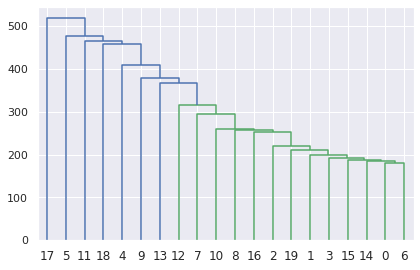

In [0]:
dendrogram(hier)
plt.show()

In [0]:
threshold = 250

In [0]:
clustered = fcluster(hier, threshold, criterion='distance')
clustered

array([ 1,  1,  1,  1,  9, 12,  1,  5,  3,  8,  4, 11,  6,  7,  1,  1,  2,
       13, 10,  1], dtype=int32)

今回のデータでは複数のグループができなかったが、データによっては下図のような構成となり、しきい値で
クラスタ数が変化する

![代替テキスト](https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.amazonaws.com%2F0%2F195884%2F9042e8c6-4be4-f130-b7d5-218df15b434c.png?ixlib=rb-1.2.2&auto=compress%2Cformat&gif-q=60&s=168e0d361cc78ea6c2e418d27d701f63)